## Validation notebook for MW data cubes

- quick look at cube
- make channel maps
- make moment 1 and moment 0 maps
- calculate and plot rms, min, max
- make peak intensity map
- extract spectra at the positions of continuum sources (based on NVSS)


Based on: http://localhost:8888/notebooks/Research/High_lat_HI/ASKAP_data/test_cube.ipynb

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.io import fits
from spectral_cube import SpectralCube
from spectral_cube import BooleanArrayMask
from astropy.convolution import Gaussian1DKernel, convolve
import aplpy  
from astropy.wcs import WCS
from reproject import reproject_interp
from astroquery.vizier import Vizier
from astroquery.skyview import SkyView
from astropy.time import Time
import pandas as pd

Vizier.ROW_LIMIT = -1

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '16'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
%matplotlib inline

In [40]:
# make sube directories for the plots with the field name

!mkdir ./plots/NGC5044_3B
!mkdir ./spectra_plots/NGC5044_3B
!mkdir ./moment_maps/NGC5044_3B

mkdir: ./plots/NGC5044_3B: File exists
mkdir: ./spectra_plots/NGC5044_3B: File exists


In [3]:
# read in data cube

input_dir = '/Users/denes/Research/high_lat_HI/ASKAP_data/data_cubes/'
#data_cube = 'NGC4808_combine_MW.fits'
#field = 'NGC4808'

data_cube = 'image.restored.i.SB40905.cube.MilkyWay.contsub.fits'
field = 'NGC5044_3B'

cube = SpectralCube.read('{}{}'.format(input_dir, data_cube))  # Open the FITS file for reading


INFO: Auto-setting vmin to -1.966e-01 [aplpy.core]
INFO: Auto-setting vmax to  2.237e-01 [aplpy.core]


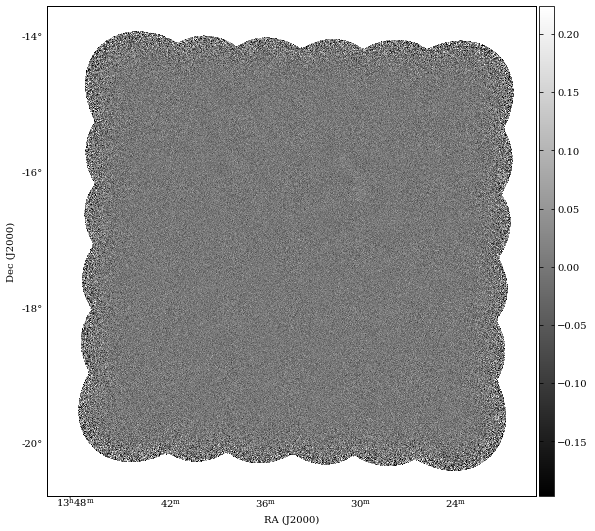

In [4]:
# Have a quick look at the cube

cube_2 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
subcube = cube_2.spectral_slab(40*u.km/u.s,60*u.km/u.s)

subcube.moment0(axis=0).quicklook()

In [5]:
# check the dimensions of the cube
cube.shape

(432, 4319, 4320)

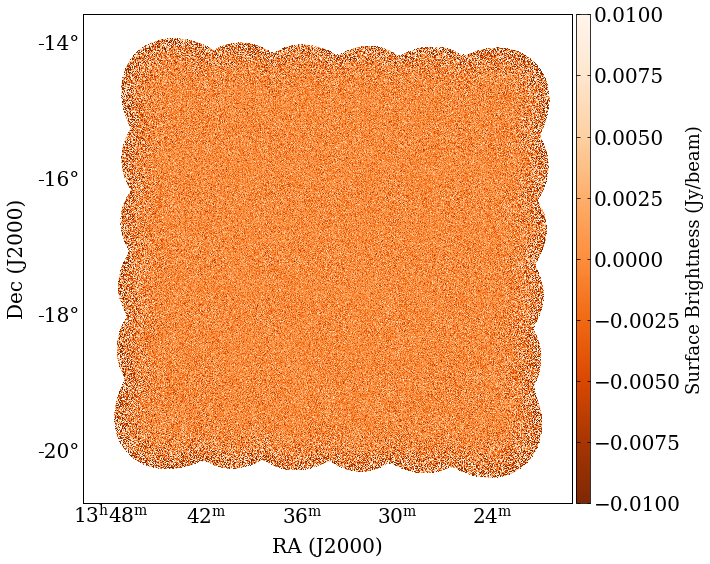

In [44]:
# check some channels

def plot_channel_map(ch):
    f = aplpy.FITSFigure(cube[ch,:,:].hdu)  
    f.show_colorscale(cmap='Oranges_r', vmin=-0.01, vmax=0.01)  
    #f.recenter(153.94, -27.374, radius=4.)

    f.add_colorbar()
    f.colorbar.set_axis_label_text('Surface Brightness (Jy/beam)')
    f.colorbar.set_axis_label_font(size=18)
    f.colorbar.set_font(size=20, weight='medium', family='serif')

    f.axis_labels.set_font(size=20, weight='medium', family='serif')
    f.tick_labels.set_font(size=20, weight='medium', family='serif')
    #f.save('./plots/{}_channel_{}.png'.format(data_cube[:-5],ch), dpi=200) 

plot_channel_map(140)

## Make a moment 0 and 1 maps

INFO: Auto-setting vmin to -1.915e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.894e-01 [aplpy.core]


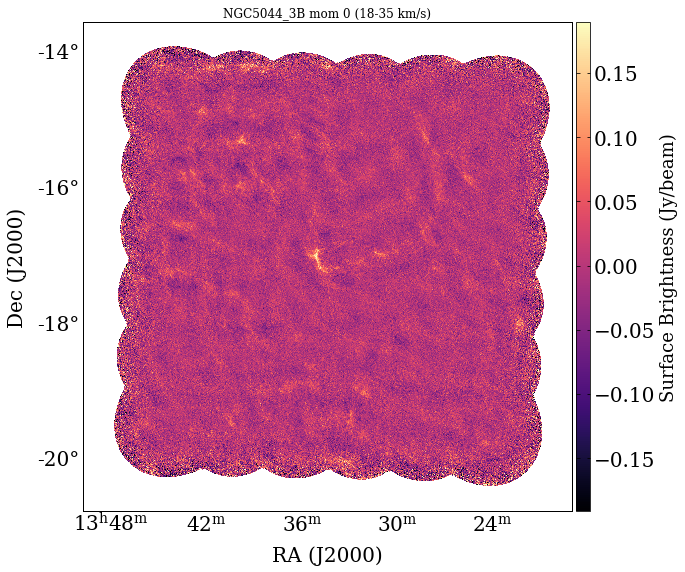

In [56]:
def make_moment_map(vel):
    cube_3 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
    subcube = cube_3.spectral_slab(vel[0]*u.km/u.s,vel[1]*u.km/u.s)
    moment_0_v3 = subcube.moment(order=0)

    f = aplpy.FITSFigure(moment_0_v3.hdu)  
    f.show_colorscale(cmap='magma')  
    #f.recenter(153.94, -27.374, radius=4.)
    
    f.set_title('{} mom 0 ({}-{} km/s)'.format(field, vel[0], vel[1]))
    f.add_colorbar()
    f.colorbar.set_axis_label_text('Surface Brightness (Jy/beam)')
    f.colorbar.set_axis_label_font(size=18)
    f.colorbar.set_font(size=20, weight='medium', family='serif')
    
    f.axis_labels.set_font(size=20, weight='medium', family='serif')
    f.tick_labels.set_font(size=20, weight='medium', family='serif')
    f.save('./moment_maps/{}/{}_mom_0_{}-{}.png'.format(field, data_cube[:-5], vel[0],vel[1]), dpi=200) 

    hdul = fits.HDUList([moment_0_v3.hdu])
    hdul[0].header['BMIN']=0.5
    hdul[0].header['BMAJ']=0.5
    hdul[0].header['BPA']=0
    hdul.writeto('./moment_maps/{}_mom_0_{}-{}kms.fits'.format(data_cube[:-5], vel[0],vel[1]), overwrite=True)

# make_moment_map([-20,-10])
# make_moment_map([-30,10])
# make_moment_map([-30,-25])
# make_moment_map([-25,-20])
# make_moment_map([-20,-15])
# make_moment_map([-15,-10])
#make_moment_map([-10,-5])
#make_moment_map([-5,0])
#make_moment_map([0,5])
#make_moment_map([5,10])
# make_moment_map([0,10])
# make_moment_map([10,20])
# make_moment_map([20,30])
# make_moment_map([30,40])
# make_moment_map([40,50])


make_moment_map([18,35])

/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: divide by zero encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /
/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


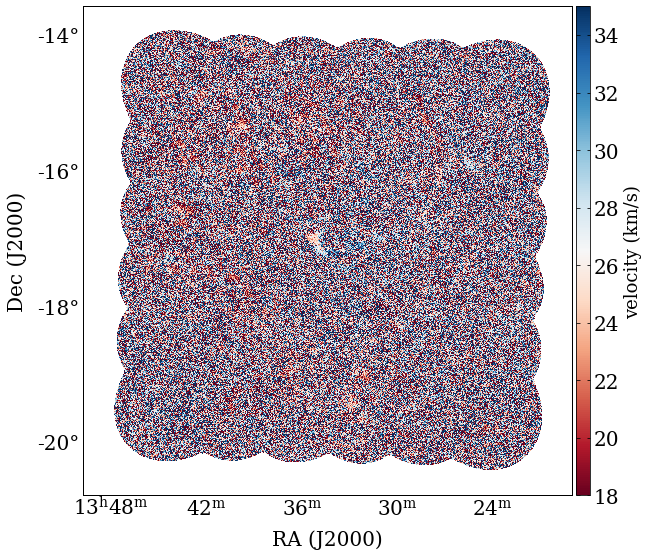

In [57]:
def make_moment1_map(vel):
    cube_3 = cube.with_spectral_unit(u.km/u.s, velocity_convention='optical', rest_value=1.420405752 * u.GHz) 
    subcube = cube_3.spectral_slab(vel[0]*u.km/u.s,vel[1]*u.km/u.s)
    moment_1_v3 = subcube.moment(order=1)

    f = aplpy.FITSFigure(moment_1_v3.hdu)  
    f.show_colorscale(cmap='RdBu', vmin=vel[0], vmax=vel[1])  
    #f.recenter(153.94, -27.374, radius=4.)
    
    f.add_colorbar()
    f.colorbar.set_axis_label_text('velocity (km/s)')
    f.colorbar.set_axis_label_font(size=18)
    f.colorbar.set_font(size=20, weight='medium', family='serif')
    
    f.axis_labels.set_font(size=20, weight='medium', family='serif')
    f.tick_labels.set_font(size=20, weight='medium', family='serif')
    #f.recenter(154.403343-(154.403343-150.377726)/2, -30.446054+(30.446054-27.849166)/2, width=2., height=1.2)
    f.save('./moment_maps/{}/{}_mom_1_{}-{}.png'.format(field, data_cube[:-5], vel[0],vel[1]), dpi=200) 
    
make_moment1_map([18,35])

## RMS in the cube

In [9]:
askap = fits.open('{}{}'.format(input_dir, data_cube))  # Open the FITS file for reading
d_askap = askap[0].data
h_askap = askap[0].header
w_askap = WCS(h_askap, askap)

In [10]:
# calculate per channel properties of the cube
# this section takes the longest
# this section could probably be optimized 

rms = []
min_a = []
max_a = []

for i in range(cube.shape[0]):
    rms.append(np.sqrt(np.nanmean(np.square(d_askap[i, 0, :, :]))))
    min_a.append(np.nanmin(d_askap[i, 0, :, :]))
    max_a.append(np.nanmax(d_askap[i, 0, :, :]))

#print('RMS:',rms) 

restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) 

<ipython-input-10-9082bf7d1536>:10: RuntimeWarning: Mean of empty slice
  rms.append(np.sqrt(np.nanmean(np.square(d_askap[i, 0, :, :]))))
<ipython-input-10-9082bf7d1536>:11: RuntimeWarning: All-NaN slice encountered
  min_a.append(np.nanmin(d_askap[i, 0, :, :]))
<ipython-input-10-9082bf7d1536>:12: RuntimeWarning: All-NaN slice encountered
  max_a.append(np.nanmax(d_askap[i, 0, :, :]))


In [11]:
#print('RMS:',rms) 

# write per channel rms into csv file 

df_spectra = pd.DataFrame()
df_spectra['velocity'] = vel_askap 
df_spectra['rms'] = rms
df_spectra['min'] = min_a
df_spectra['max'] = max_a
df_spectra.to_csv('./{}_rms_spectrum.txt'.format(field), sep='\t')


IndexError: invalid index to scalar variable.

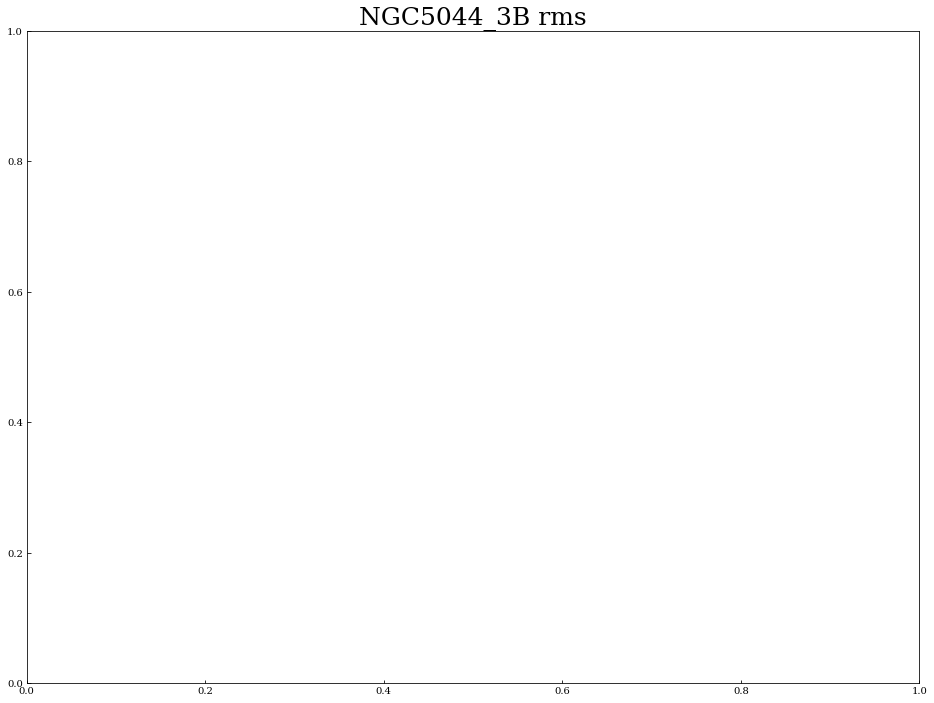

In [55]:
# make plots of the cube properties

#print(len(rms))

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)
plt.title('{} rms'.format(field), fontsize=25)
#plt.plot(vel_askap[:-35],rms[:-35], lw=3)
plt.plot(vel_askap[:-12],rms[:-12], lw=3)
plt.grid(linestyle=':')
plt.ylabel('Flux value [Jy/beam]', fontsize=28)
plt.xlabel("velocity [km/s]", fontsize=28)
#plt.xlim(0,235)
rms_av = np.average(rms[6:-35])
print('average rms:',rms_av)
rms_max = np.max(rms)
#plt.ylim(rms_av-0.0003, rms_max+0.0001)
ax1.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('./plots/{}/{}_rms.png'.format(field, field))

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)
plt.title('{} min, max'.format(field), fontsize=25)
#plt.plot(vel_askap[:-35],min_a[:-35], lw=3)
#plt.plot(vel_askap[:-35],max_a[:-35], lw=3)
plt.plot(vel_askap[:-12],min_a[:-12], lw=3)
plt.plot(vel_askap[:-12],max_a[:-12], lw=3)
plt.grid(linestyle=':')
plt.ylabel('Flux value [Jy/beam]', fontsize=28)
plt.xlabel("velocity [km/s]", fontsize=28)
#plt.xlim(0,235)
min_av = np.average(min_a[6:-35])
max_av = np.average(max_a[6:-35])
print('average min, max:', min_av, max_av)
rms_max = np.max(rms)
#plt.ylim(rms_av-0.0001, rms_max+0.0001)
ax1.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('./plots/{}/{}_min_max.png'.format(field, field))


with open('{}_average_values.txt'.format(field), 'w') as f:
    f.write('average rms: {} \n'.format(rms_av))
    f.write('average min, max: {}, {}'.format(min_av, max_av))

## Peak intensity map

In [13]:
cube.shape[0]

432

In [14]:
# this also takes pretty long


peak = np.max(d_askap[6:cube.shape[0]-15,:,:,:], axis=0)  # some beams are missing channels for NGC4808


In [15]:
d_askap[0:420,:,:,:].shape

(420, 1, 4319, 4320)

0.07351648


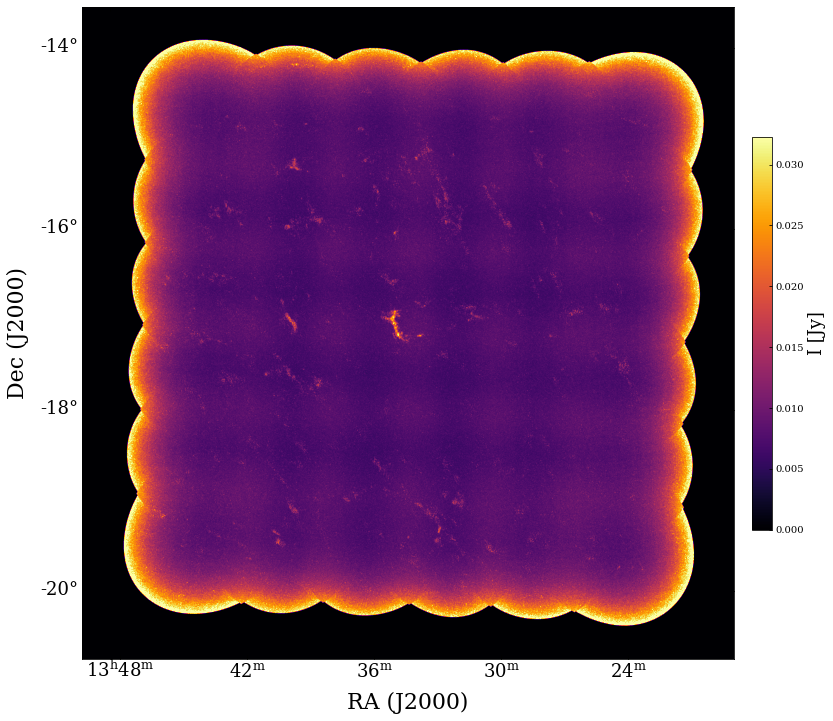

In [18]:
moment_map = './moment_maps/{}_mom_0_0-5kms.fits'.format(data_cube[:-5])

hi_data = fits.open(moment_map)  # Open the FITS file for reading

d = hi_data[0].data
h = hi_data[0].header


im = np.nan_to_num(peak[0,:,:])
print(np.max(im))

wcs = WCS(h)

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(projection=wcs)
image = plt.imshow(im, cmap='inferno', vmax=np.percentile(im,99))

#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
cbar_hi = plt.colorbar(image, orientation='vertical', fraction=0.022, pad=0.02)
cbar_hi.set_label('I [Jy]', size=18)

#overlay = ax.get_coords_overlay('galactic')
#overlay.grid(color='k', ls='dotted')
#overlay[0].set_axislabel('Galactic Longitude',fontsize=22)
#overlay[1].set_axislabel('Galactic Latitude',fontsize=22)

#ax.set_xlim(x_lim)
#ax.set_ylim(y_lim)

fig.savefig('./plots/{}/{}_peak_intensity.png'.format(field, field), dpi=200, bbox_inches='tight')

# write the peak intensity map into a fits file 
hi_data[0].data = im

hi_data.writeto('./moment_maps/{}_peak_intensity.fits'.format(data_cube[:-5]), overwrite=True)


## Extract spectra

<SkyCoord (ICRS): (ra, dec) in deg
    (204.06455833, -16.72901944)>
number of sources: 20


<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.
<ipython-input-51-e1c0b98b7747>:28: Runti

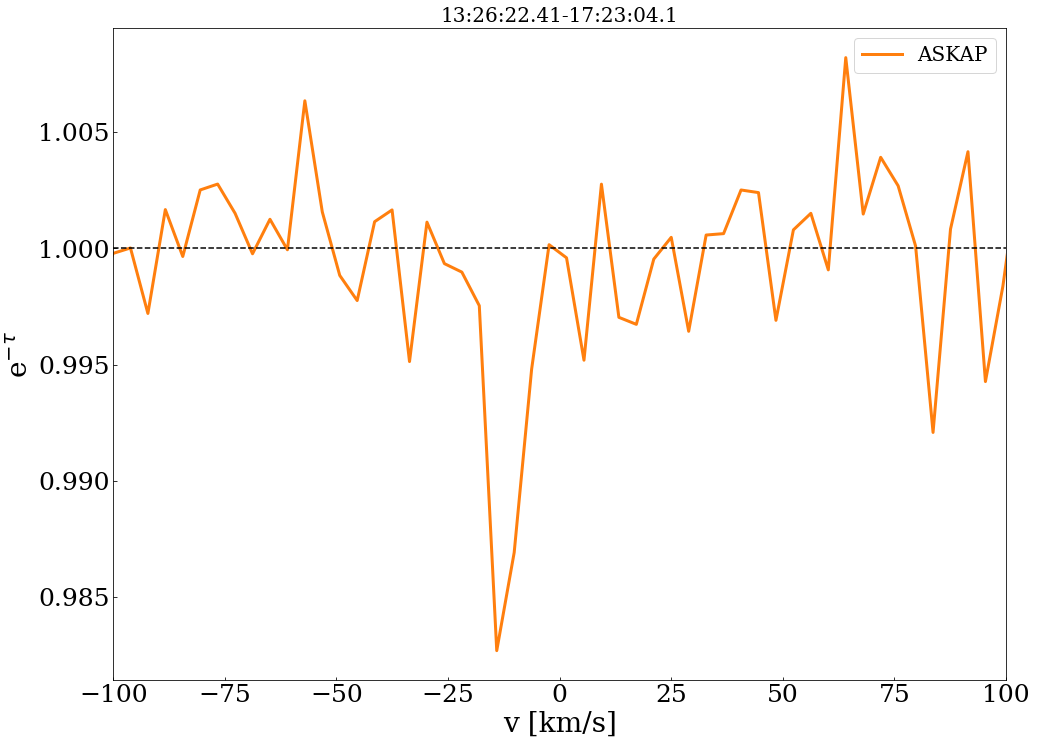

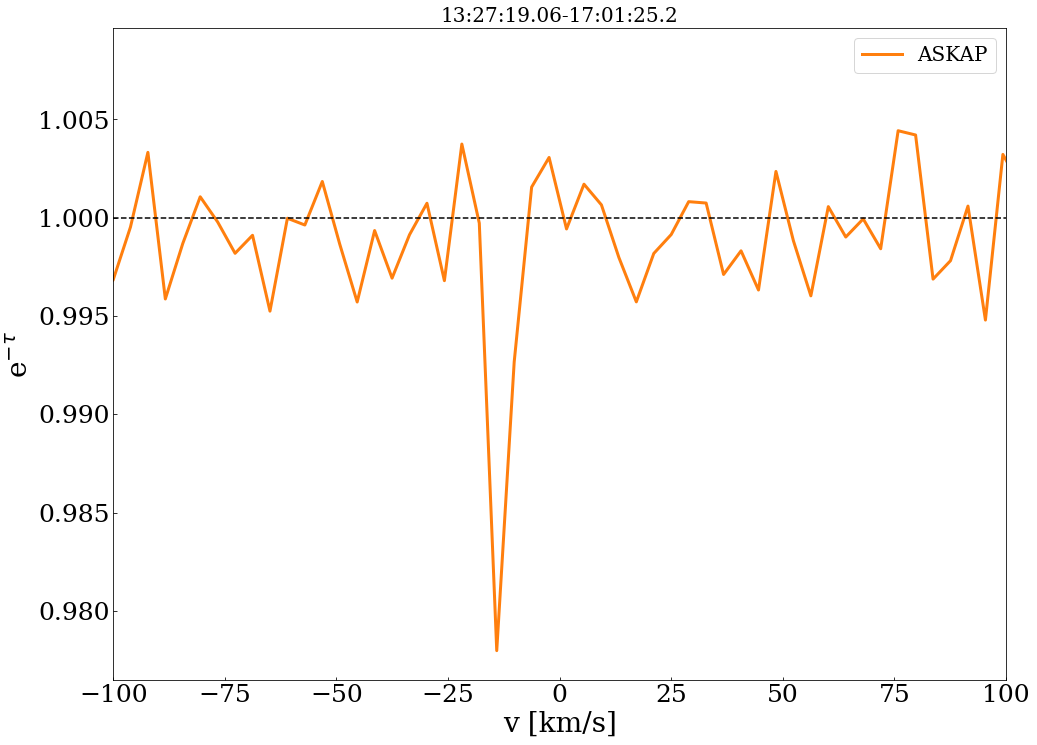

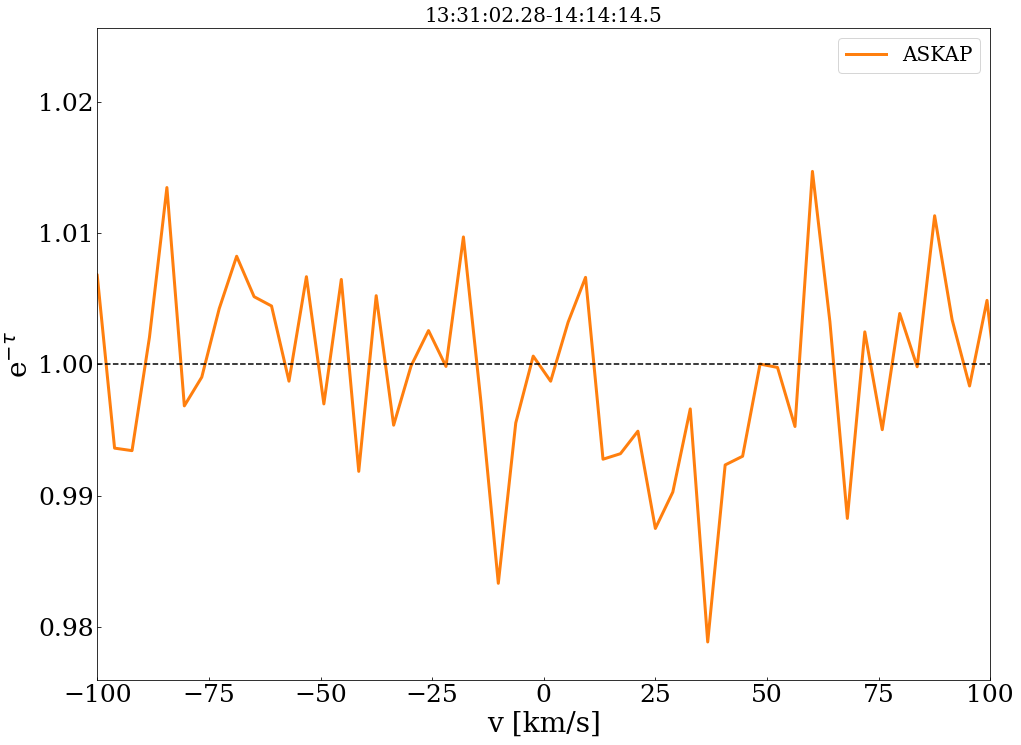

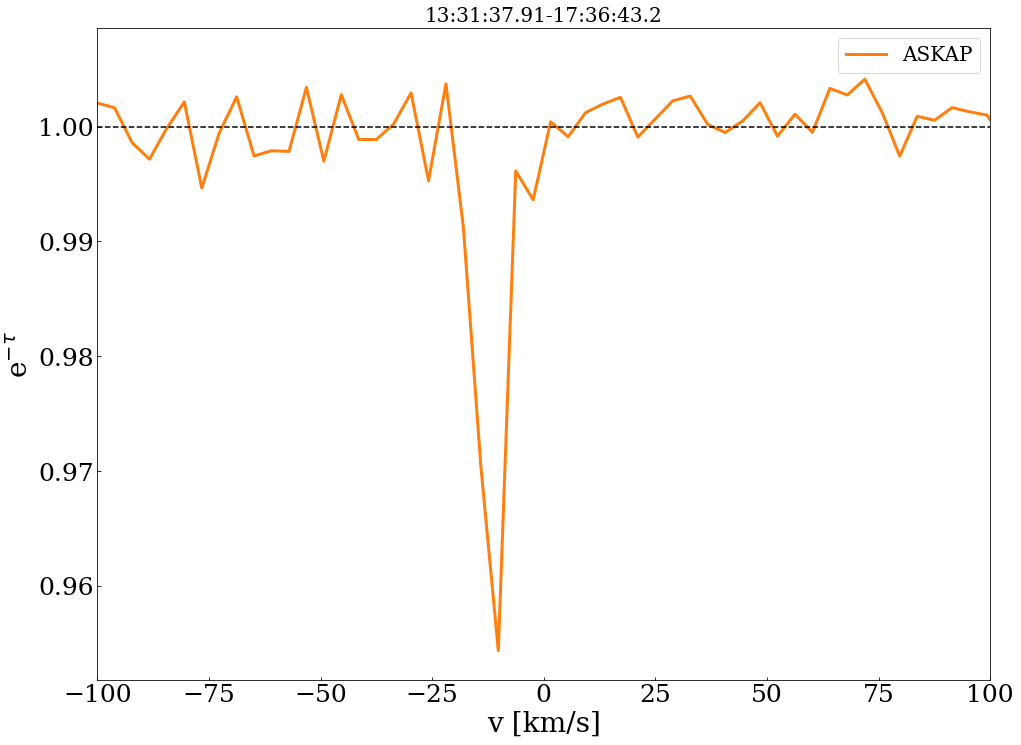

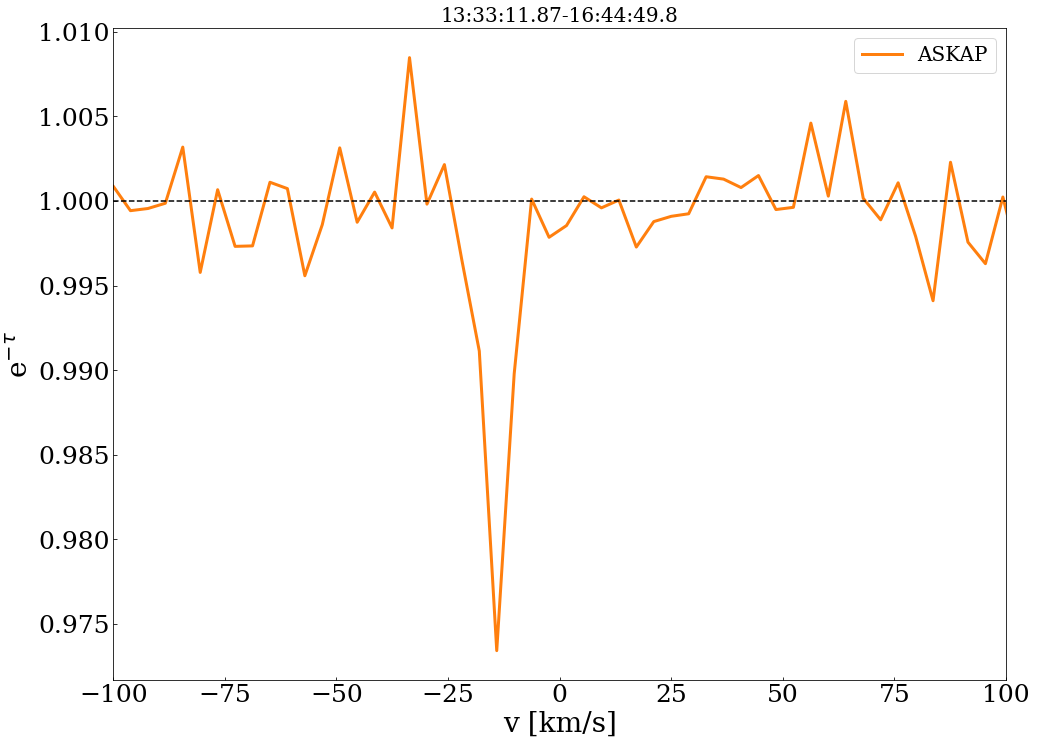

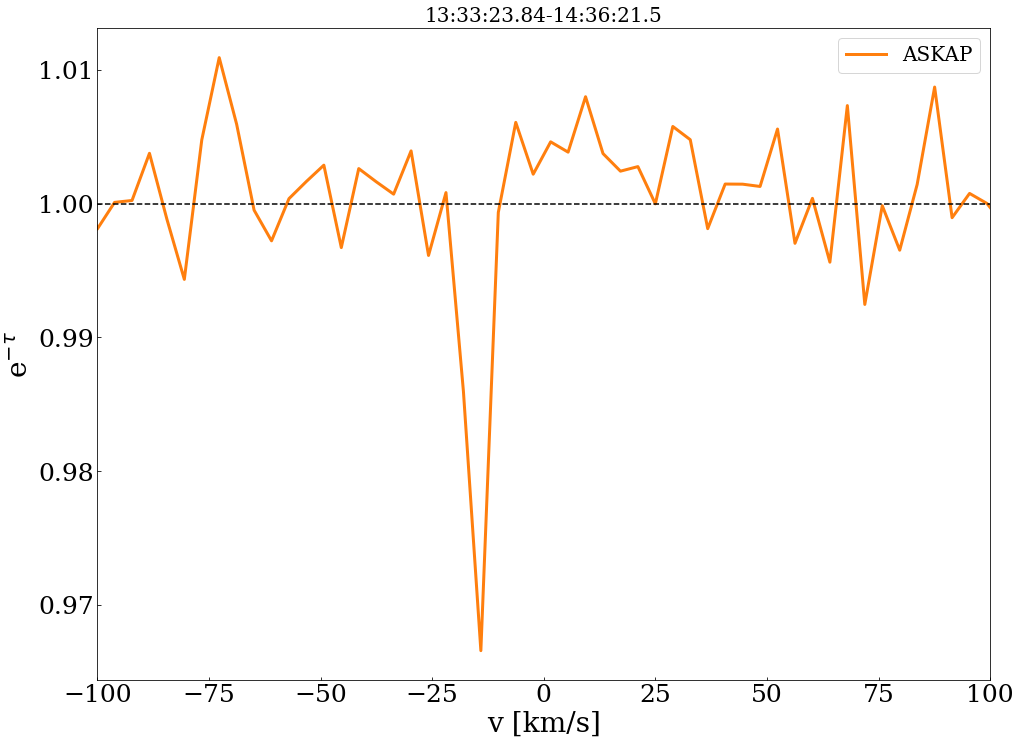

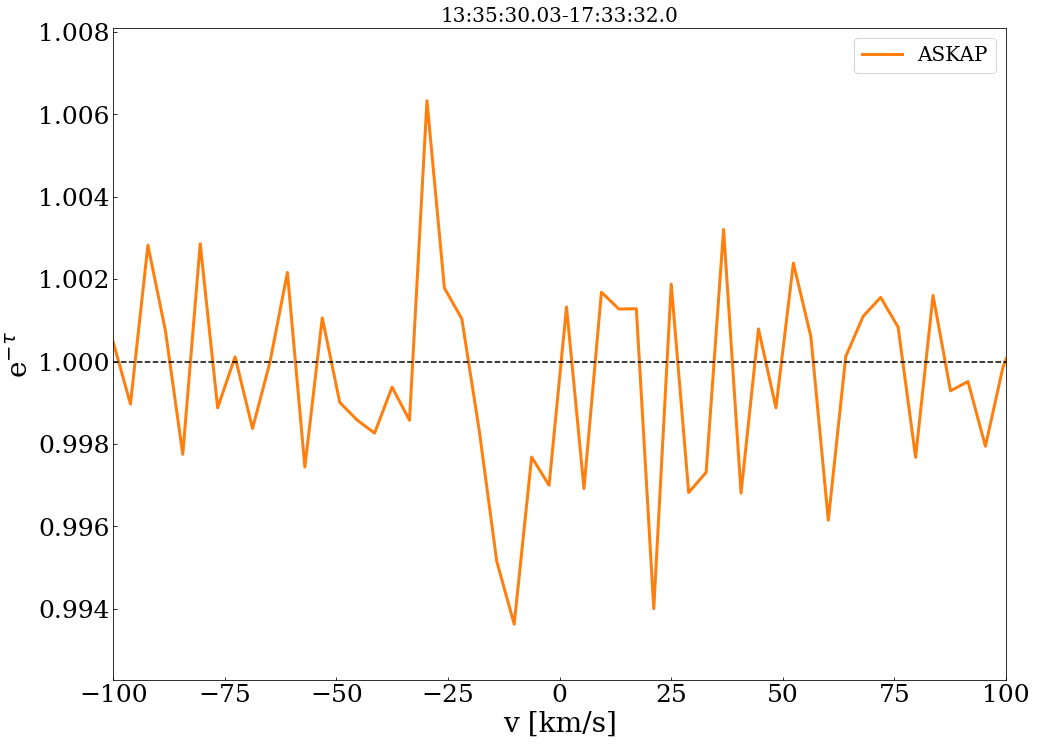

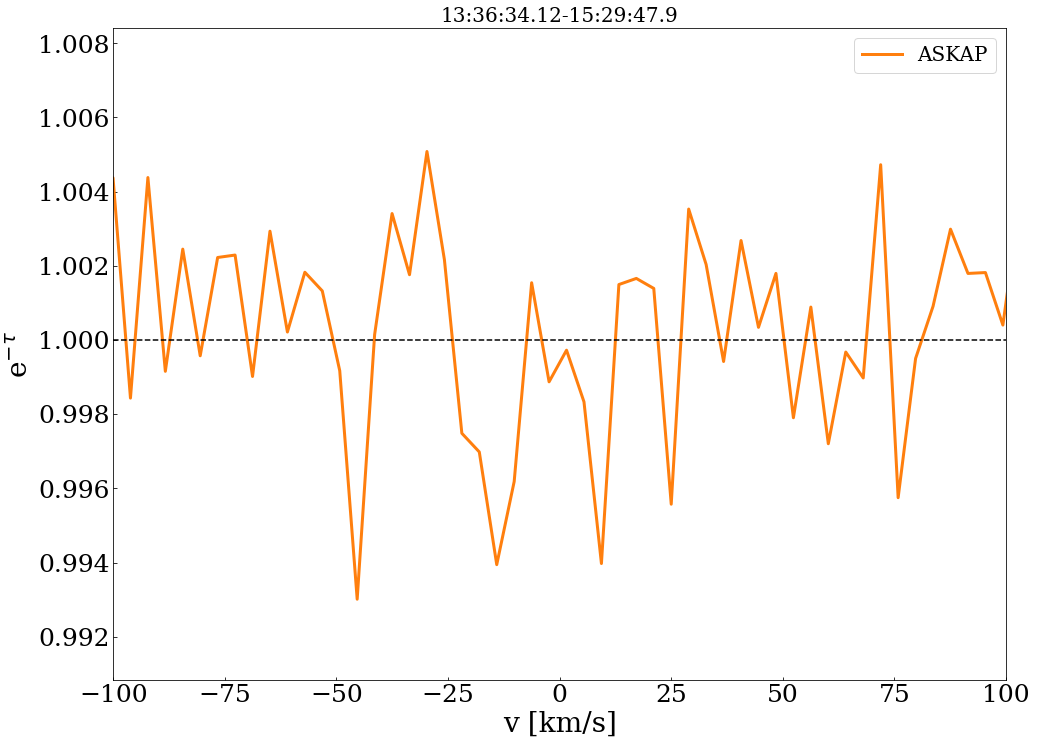

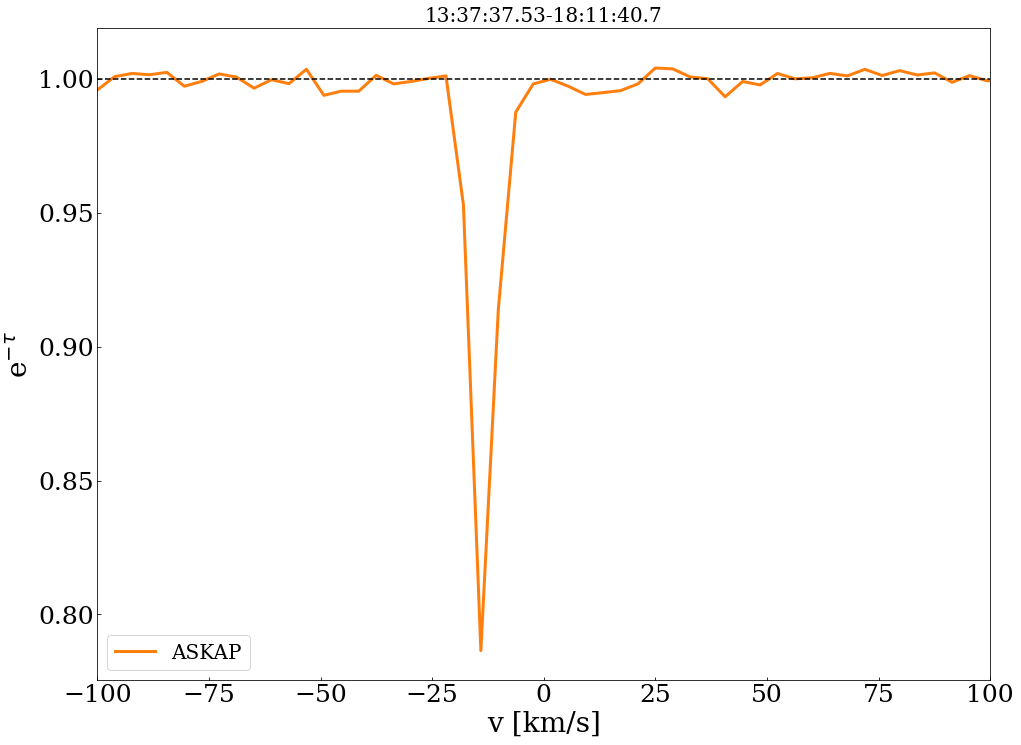

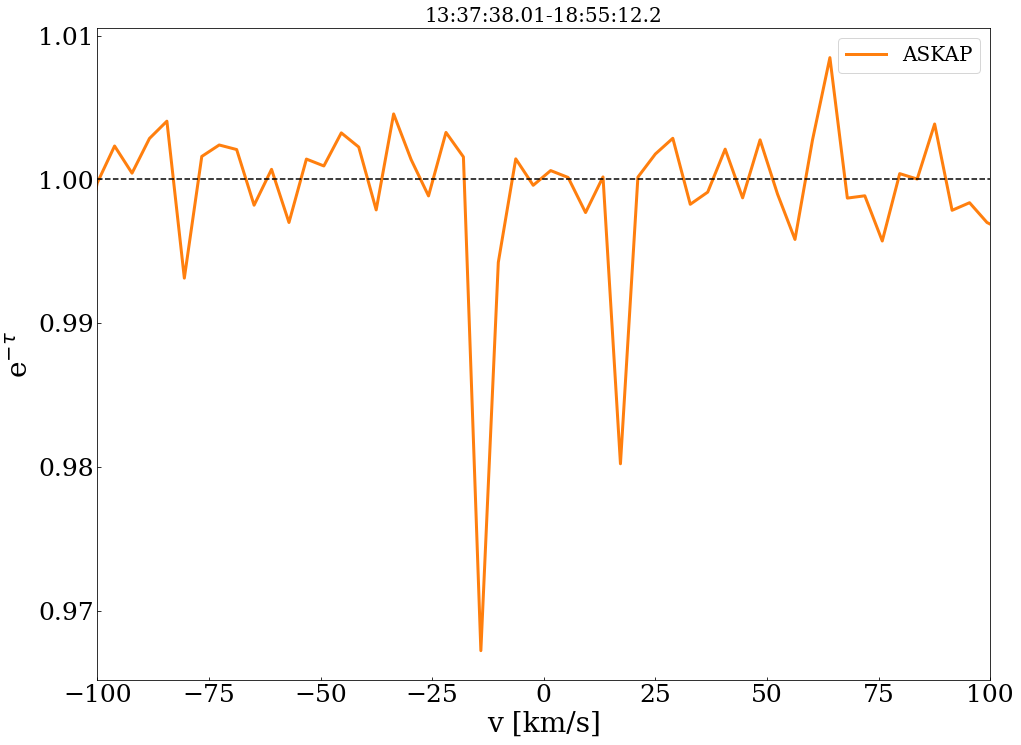

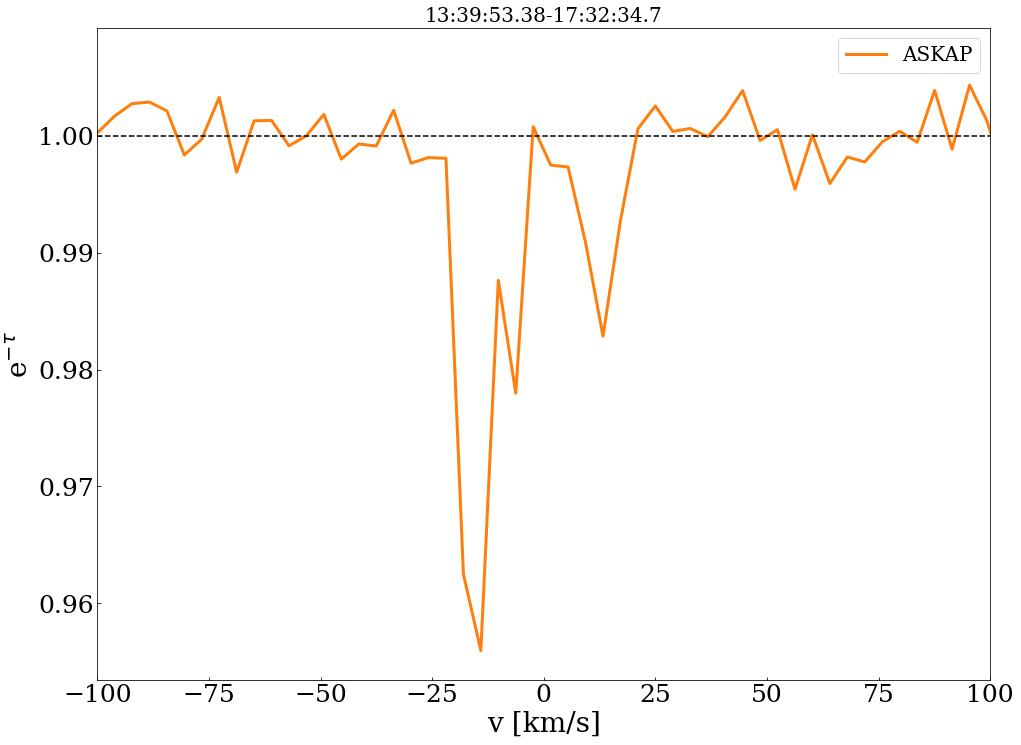

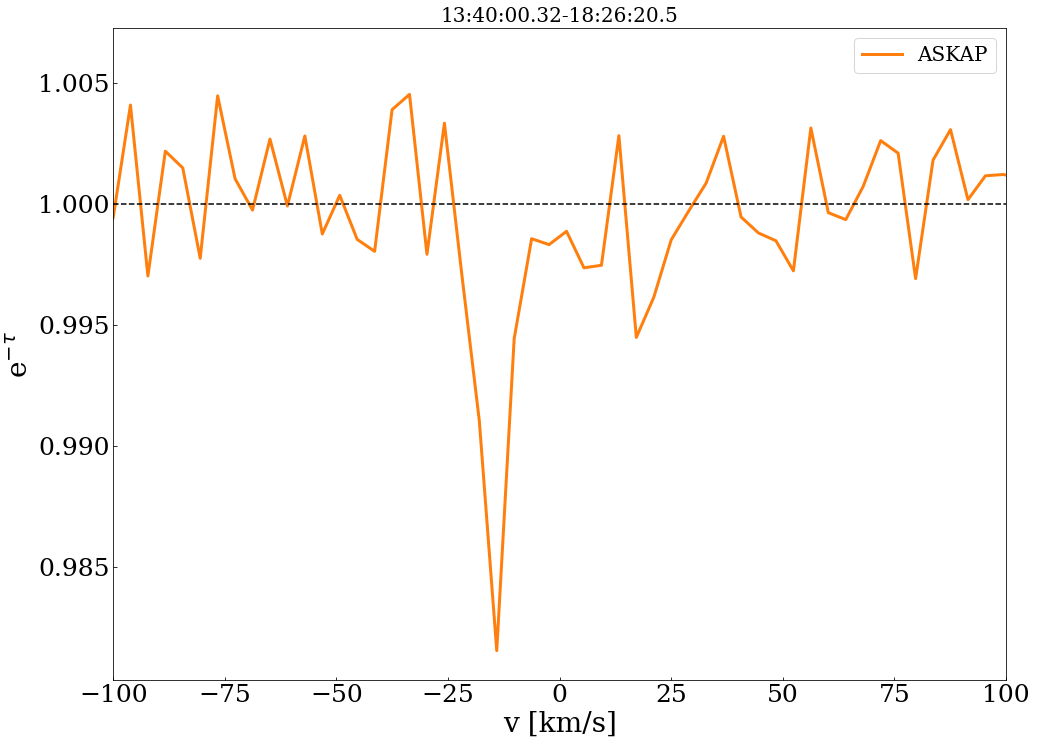

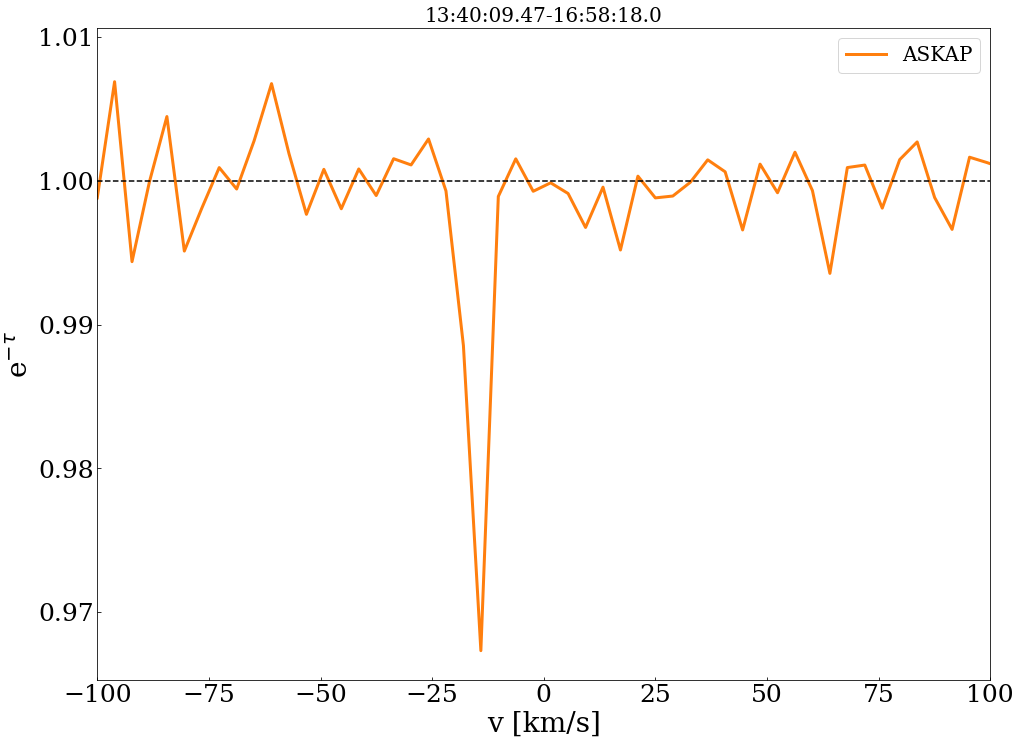

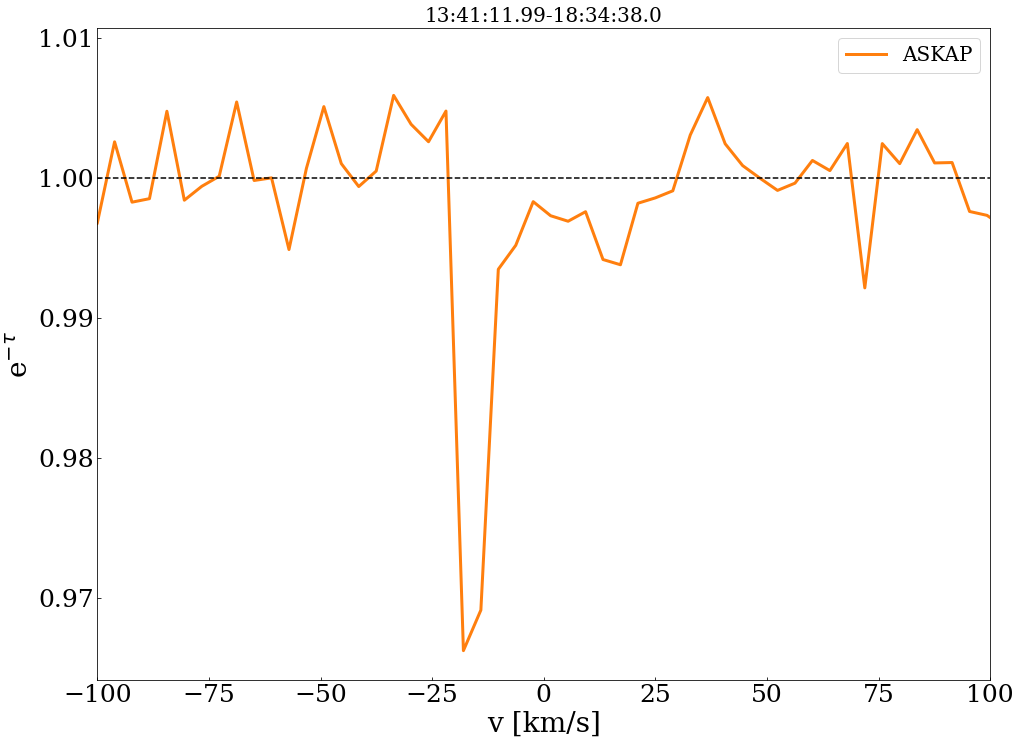

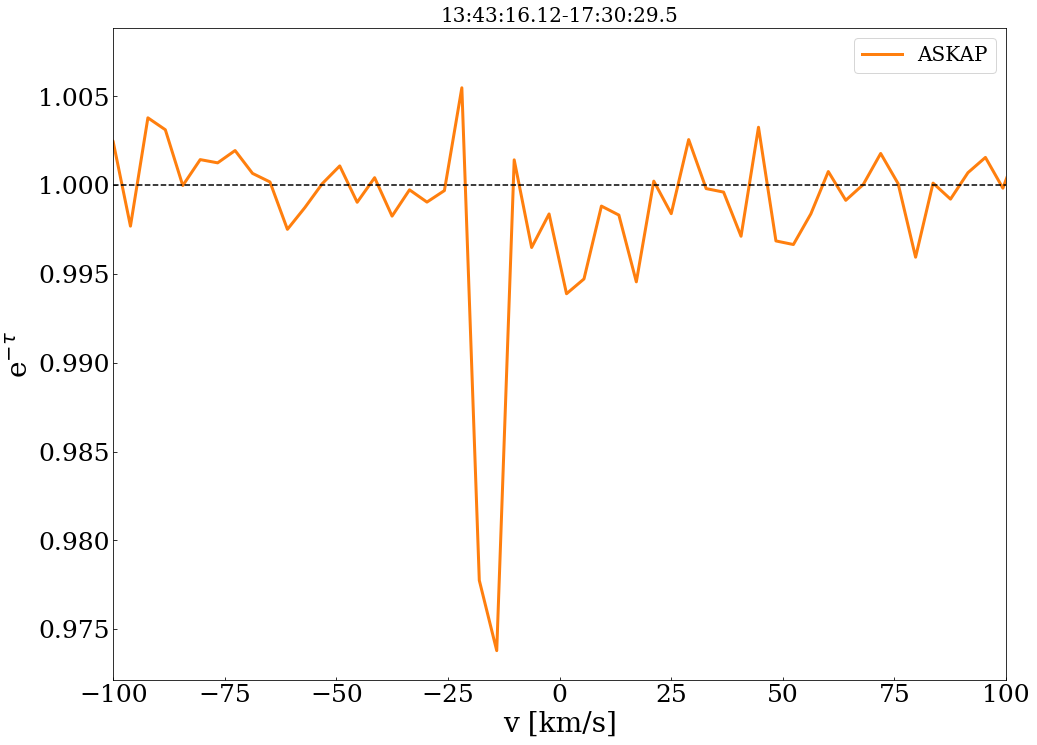

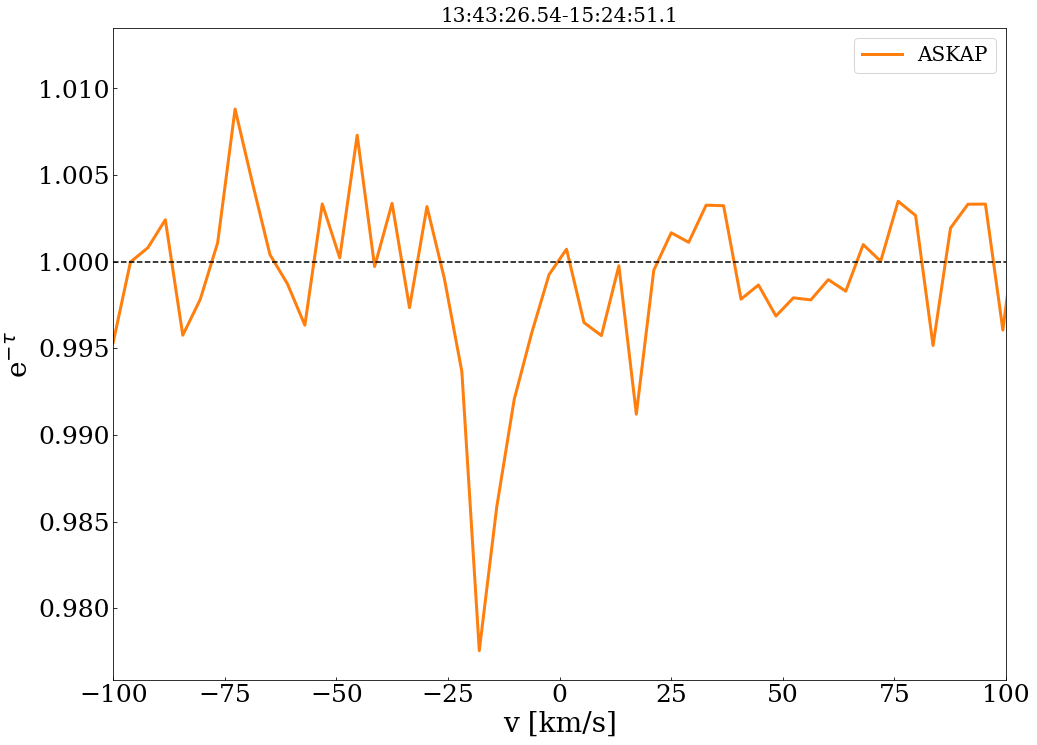

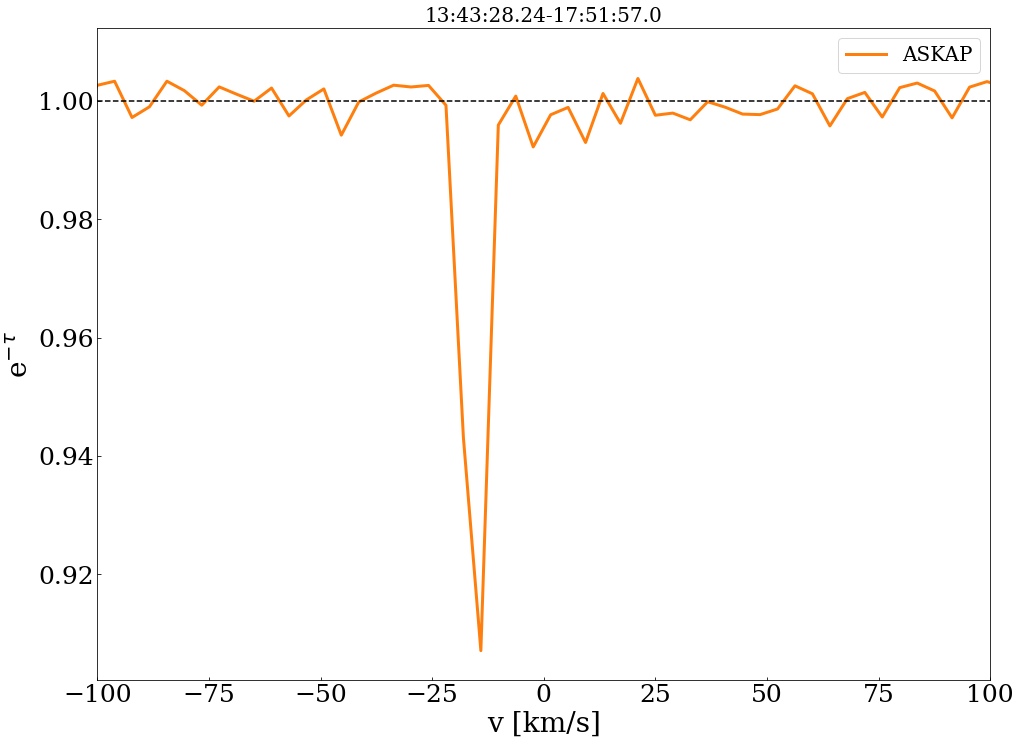

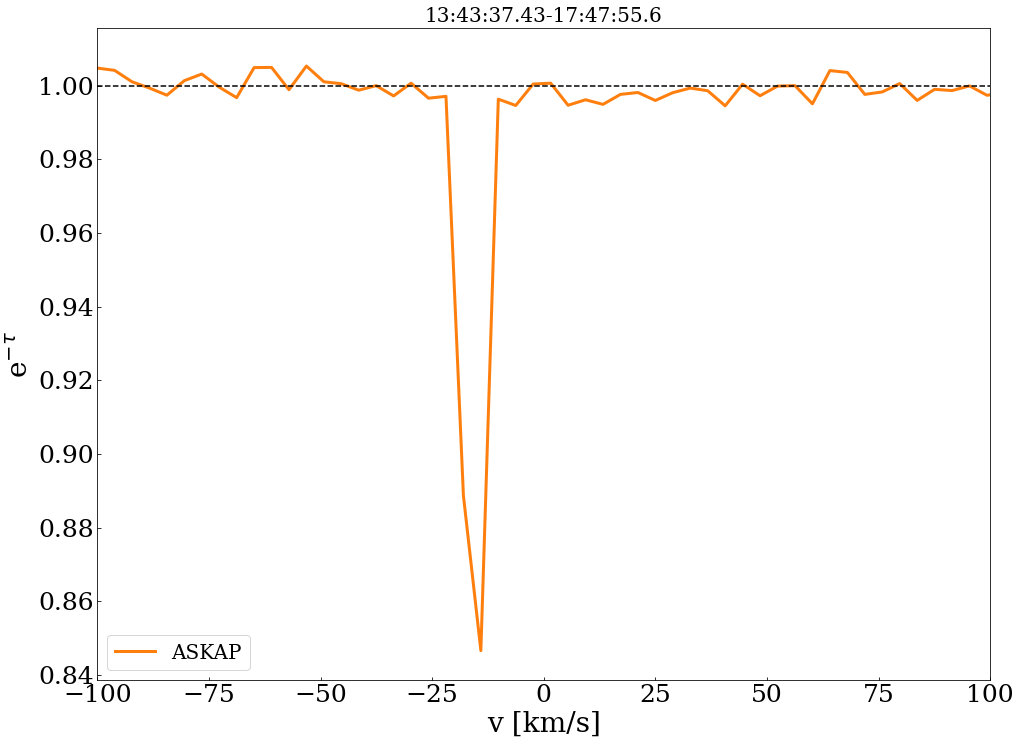

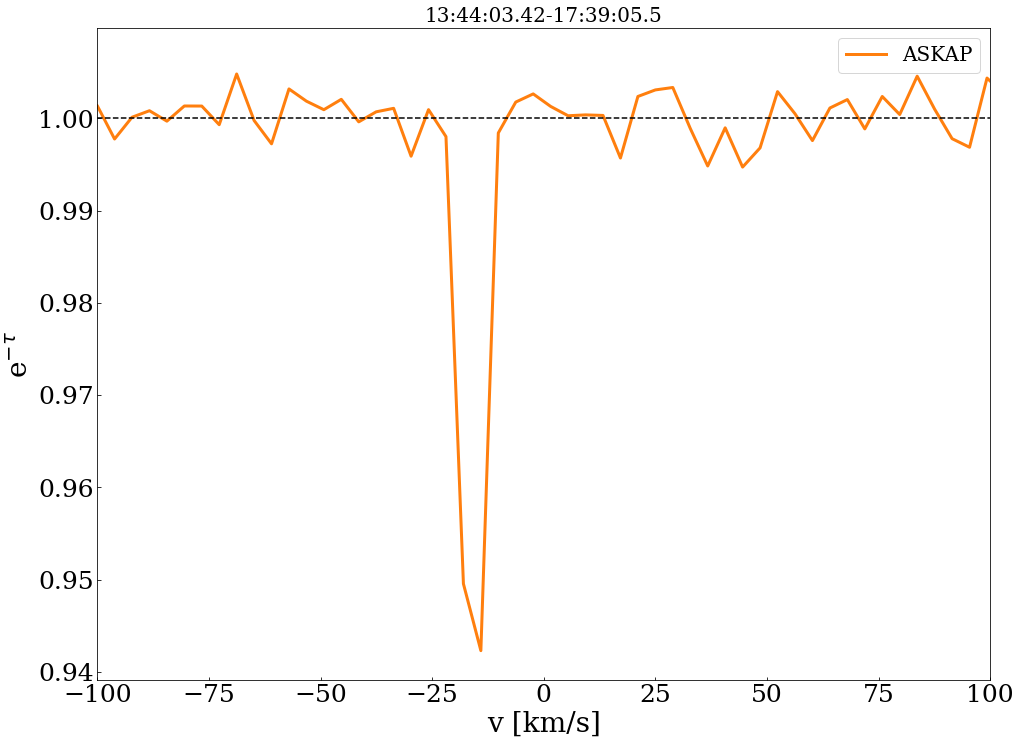

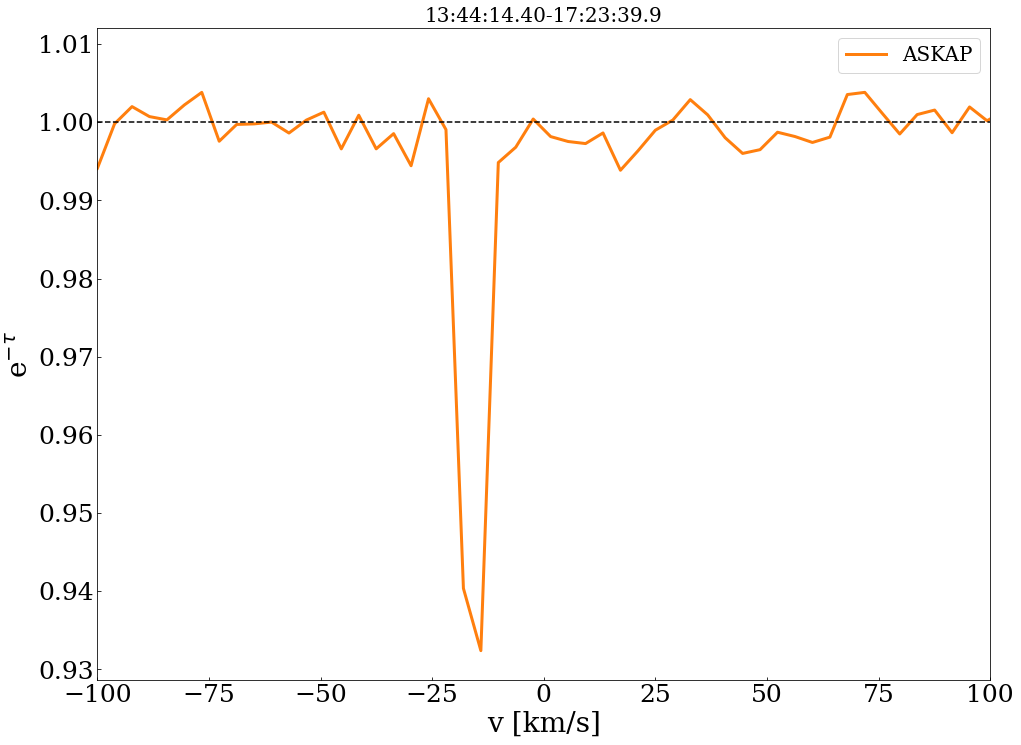

In [51]:
#print(h_askap['CRVAL1'], h_askap['CRVAL2'])
coordinate = '{} {}'.format(h_askap['CRVAL1'], h_askap['CRVAL2'])
c = SkyCoord(coordinate, unit=(u.deg, u.deg))
print(c)

MRO = EarthLocation.of_site('mro') 
#keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, lon=-155.4783*u.deg, height=4160*u.m)
barycorr = c.radial_velocity_correction(obstime=Time('2021-11-14'), location=MRO) 

restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2

result = Vizier(column_filters={"S1.4":">200"}, row_limit=-1).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-2.5, c.ra.deg+2.5), DEJ2000='>{} & <{}'.format(c.dec.deg-2.5, c.dec.deg+2.5))
#print('number of sources:',len(result[0]))
#result = Vizier.query_constraints(catalog='VIII/81B/sumss212',RAJ2000='>{} & <{}'.format(c.ra.deg-16, c.ra.deg+16), DEJ2000='>{} & <{}'.format(c.dec.deg-3., c.dec.deg+3.), dMajAxis='<45', St='>150')
print('number of sources:',len(result[0]))
#print(result[0]['RAJ2000'][0],result[0]['DEJ2000'][0])

for i in range(len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    pixels_askap = c2.to_pixel(w_askap)
    #print(coord )
    #print(pixels_askap)

    spectrum_askap = cube[:, int(pixels_askap[1]), int(pixels_askap[0])]  # 10:09:10 -28:55:57
    tau_askap = np.log(spectrum_askap.value +1) * -1.
    rms = np.sqrt(np.mean(spectrum_askap.value**2))

    # plot
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    ax.set_title('{}{}'.format(result[0]['RAJ2000'][i].replace(' ',':'),result[0]['DEJ2000'][i].replace(' ',':')), fontsize=20)

    plt.plot(vel_askap, spectrum_askap.value+1, 'C1', linewidth=3, label='ASKAP')
    ax.axhspan(1-3*rms, 1+rms, alpha=0.5, color='lightgrey')
    #plt.title('102809-264418', fontsize=30)
    plt.ylabel(r'e$^{-\tau}$', fontsize=28)
    plt.xlabel("v [km/s]", fontsize=28)
    #plt.xlim(-100,100)
    #plt.ylim(0.92,1.02)
    plt.axhline(1, color='k', linestyle='--')
    plt.legend(fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=25)
    fig.savefig('./spectra_plots/{}/{}{}_ASKAP_spectra.png'.format(field, result[0]['RAJ2000'][i].replace(' ',''),result[0]['DEJ2000'][i].replace(' ','')))
    
    

## Additional stuff

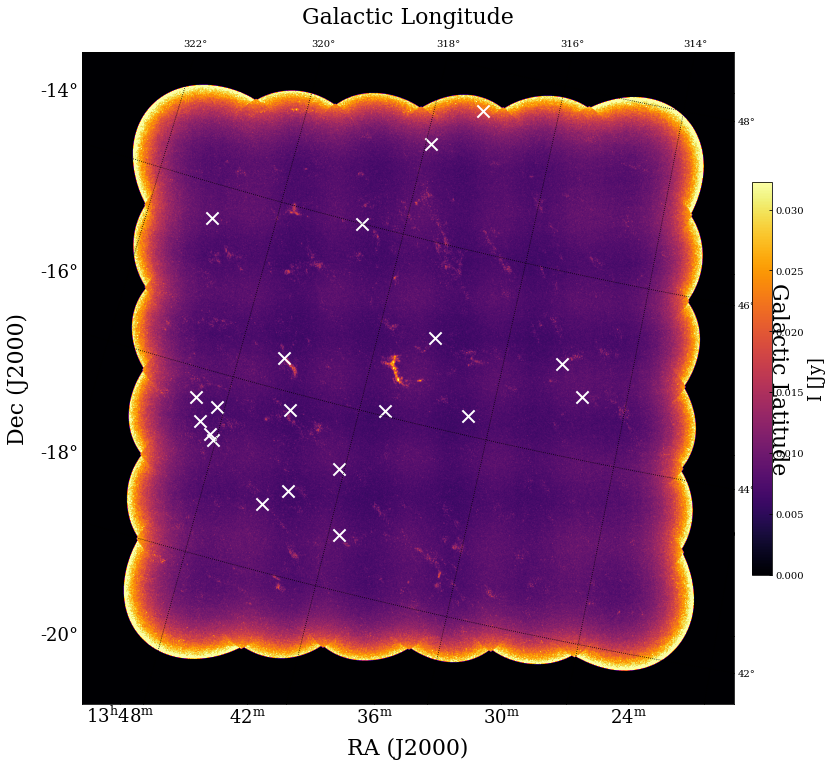

In [53]:
moment_map = './moment_maps/{}_peak_intensity.fits'.format(data_cube[:-5])

hi_data = fits.open(moment_map)  # Open the FITS file for reading

d = hi_data[0].data
h = hi_data[0].header

wcs = WCS(h)

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(projection=wcs)
image = plt.imshow(d, cmap='inferno', vmax=np.percentile(im,99))

#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
cbar_hi = plt.colorbar(image, orientation='vertical', fraction=0.022, pad=0.02)
cbar_hi.set_label('I [Jy]', size=18)

result = Vizier(column_filters={"S1.4":">200"}, row_limit=-1).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-2.5, c.ra.deg+2.5), DEJ2000='>{} & <{}'.format(c.dec.deg-2.5, c.dec.deg+2.5))

for j in range(0, len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][j].replace(' ',':'),result[0]['DEJ2000'][j].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c2.ra, c2.dec, transform=ax.get_transform('fk5'), marker='x', s=150, linewidth=2, edgecolor='w', facecolor='w')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude',fontsize=22)
overlay[1].set_axislabel('Galactic Latitude',fontsize=22)

#ax.set_xlim(x_lim)
#ax.set_ylim(y_lim)

fig.savefig('./plots/{}/{}_peak_intensity_v2.png'.format(field, field), dpi=200, bbox_inches='tight')


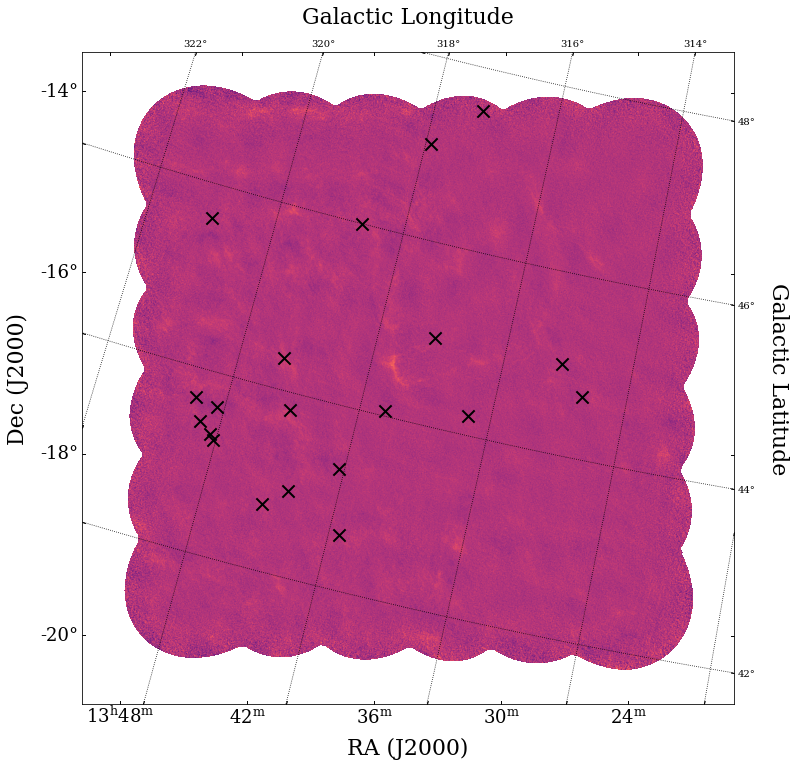

In [50]:
moment_map = './moment_maps/{}_mom_0_10-30kms.fits'.format(data_cube[:-5])

hi_data = fits.open(moment_map)  # Open the FITS file for reading

d = hi_data[0].data
h = hi_data[0].header

wcs = WCS(h)

fig = plt.figure(figsize=(16, 12))
ax = plt.subplot(projection=wcs)
image = plt.imshow(d, cmap='magma')

#ax.set_title('Hydra', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.coords['ra'].set_axislabel('RA (J2000)', fontsize=22)
ax.coords['dec'].set_axislabel('Dec (J2000)', fontsize=22)
#cbar_hi = plt.colorbar(image, orientation='vertical', fraction=0.022, pad=0.02)
#cbar_hi.set_label('I [Jy]', size=18)

result = Vizier(column_filters={"S1.4":">200"}, row_limit=-1).query_constraints(catalog='VIII/65/nvss',RAJ2000='>{} & <{}'.format(c.ra.deg-2.5, c.ra.deg+2.5), DEJ2000='>{} & <{}'.format(c.dec.deg-2.5, c.dec.deg+2.5))

for j in range(0, len(result[0])):
    coord = '{} {}'.format(result[0]['RAJ2000'][j].replace(' ',':'),result[0]['DEJ2000'][j].replace(' ',':'))
    c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
    ax.scatter(c2.ra, c2.dec, transform=ax.get_transform('fk5'), marker='x', s=150, linewidth=2, edgecolor='k', facecolor='k')

overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='k', ls='dotted')
overlay[0].set_axislabel('Galactic Longitude',fontsize=22)
overlay[1].set_axislabel('Galactic Latitude',fontsize=22)

#ax.set_xlim(x_lim)
#ax.set_ylim(y_lim)

fig.savefig('./plots/{}/{}_mom_0_10-30kms_v2.png'.format(field, field), dpi=200, bbox_inches='tight')


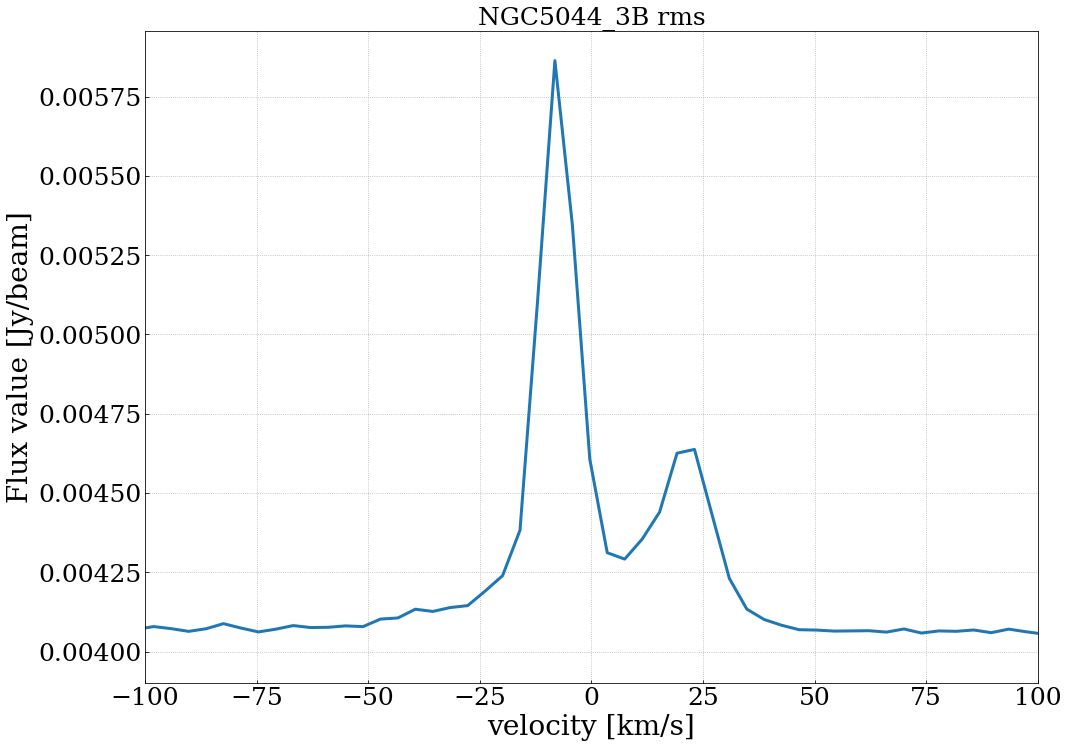

In [31]:
# make custom rms plot

rms_data = pd.read_csv('./{}_rms_spectrum.txt'.format(field), delimiter = '\t')

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111)
plt.title('{} rms'.format(field), fontsize=25)
plt.plot(rms_data['velocity'],rms_data['rms'], lw=3)
plt.grid(linestyle=':')
plt.ylabel('Flux value [Jy/beam]', fontsize=28)
plt.xlabel("velocity [km/s]", fontsize=28)
plt.xlim(-100,100)
#plt.ylim(rms_av-0.0003, rms_max+0.0001)
ax1.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('./plots/{}/{}_rms_v2.png'.format(field, field))

<SkyCoord (ICRS): (ra, dec) in deg
    (204.06455833, -16.72901944)>


<ipython-input-62-ea236468dcd0>:21: RuntimeWarning: invalid value encountered in log
  tau_askap = np.log(spectrum_askap.value +1) * -1.


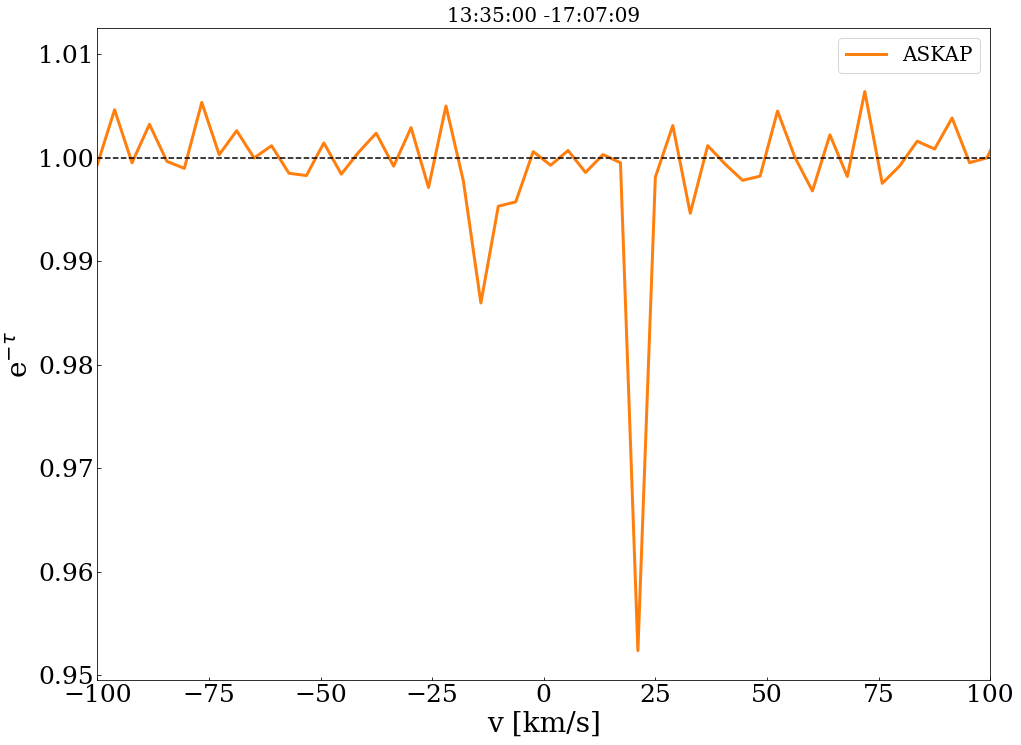

In [62]:
#print(h_askap['CRVAL1'], h_askap['CRVAL2'])
coordinate = '{} {}'.format(h_askap['CRVAL1'], h_askap['CRVAL2'])
c = SkyCoord(coordinate, unit=(u.deg, u.deg))
print(c)

MRO = EarthLocation.of_site('mro') 
#keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, lon=-155.4783*u.deg, height=4160*u.m)
barycorr = c.radial_velocity_correction(obstime=Time('2021-11-14'), location=MRO) 

restfreq = 1.420405752 * u.GHz  # rest frequency of HI
freq_to_vel = u.doppler_optical(restfreq) # using the radio convention
vel_askap = (cube.spectral_axis).to(u.km / u.s, equivalencies=freq_to_vel) - barycorr/2

coord = '13:35:00 -17:07:09'
c2 = SkyCoord(coord, unit=(u.hourangle, u.deg))
pixels_askap = c2.to_pixel(w_askap)
#print(coord )
#print(pixels_askap)

spectrum_askap = cube[:, int(pixels_askap[1]), int(pixels_askap[0])]  # 10:09:10 -28:55:57
tau_askap = np.log(spectrum_askap.value +1) * -1.
rms = np.sqrt(np.mean(spectrum_askap.value**2))

# plot
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.set_title('{}'.format(coord), fontsize=20)

plt.plot(vel_askap, spectrum_askap.value+1, 'C1', linewidth=3, label='ASKAP')
ax.axhspan(1-3*rms, 1+rms, alpha=0.5, color='lightgrey')
#plt.title('102809-264418', fontsize=30)
plt.ylabel(r'e$^{-\tau}$', fontsize=28)
plt.xlabel("v [km/s]", fontsize=28)
plt.xlim(-100,100)
#plt.ylim(0.92,1.02)
plt.axhline(1, color='k', linestyle='--')
plt.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('./spectra_plots/{}/{}_ASKAP_spectra_v2.png'.format(field, coord.replace(' ','')))


In [64]:
print(c.ra.hms, c.dec)

hms_tuple(h=13.0, m=36.0, s=15.493999992008298) -16d43m44.47s
